<center>
    <img src="http://sct.inf.utfsm.cl/wp-content/uploads/2020/04/logo_di.png" style="width:60%">
    <h1> INF285 - Computación Científica </h1>
    <h2> Polynomial Interpolation: Vandermonde matrix, Lagrange interpolation, Barycentric interpolation, and Chebyshev points. </h2>
    <h2> <a href="#acknowledgements"> [S]cientific [C]omputing [T]eam </a> </h2>
    <h2> Version: 1.33</h2>
</center>

<div id='toc' />

## Table of Contents
* [Introduction](#intro)
* [Vandermonde Matrix](#vander)
    * [Is the Vandermonde matrix really ill-conditioned?](#vandermonde_illconditioned)
* [Lagrange Interpolation](#lagrange)
    * [Plotting $L_i(x)$](#LiLagrange)
* [Barycentric interpolation](#barycentric)
* [Interpolation Error](#Error)
* [Runge Phenomenon](#runge)
* [Interpolation with Chebyshev points](#cheby)
* [Python Modules and Functions](#py)
* [Acknowledgements](#acknowledgements)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sym
from functools import reduce
import matplotlib as mpl
mpl.rcParams['font.size'] = 14
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
%matplotlib inline
from ipywidgets import interact, fixed, IntSlider, interact_manual, Checkbox, RadioButtons
sym.init_printing()
import time

<div id='intro' />

## Introduction
[Back to TOC](#toc)

Hello! In this notebook we will learn how to interpolate 1D data with polynomials. 
A polynomial interpolation consists in finding a polynomial that fits a discrete set of known data points, allowing us to construct new data points within the range of the data. 
Formally, a polynomial $p(x)$ interpolate the data $(x_1,y_1),...,(x_n,y_n)$ if $p(x_i)=y_i$ for all $i$ in $1,...,n$. 

In [2]:
# Function that evaluates the xi's points in the polynomial
def EvaluateInterpolant(D, xx):
    if D['Method']=='Vandermonde':
        p = lambda x: np.dot(D['PrecomputedData'],np.power(x,np.arange(D['n'])))
    elif D['Method']=='Lagrange':
        p = lambda x: np.dot(D['PrecomputedData'],[np.prod(x - np.delete(D['x'],j)) for j in range(D['n'])])
    elif D['Method']=='Barycentric':
        wi = D['PrecomputedData']
        xi = D['x']
        yi = D['y']
        p = lambda x: np.sum(yi*wi/(x-xi))/np.sum(wi/(x-xi)) if len(xi[xi == x])==0 else np.ndarray.item(yi[xi == x])
        # We add these three alternatives but they are analyzed in the file 'Bonus - 05 - Sinc and piecewiselinear interpolations'.
    elif D['Method']=='Newton':
        p = lambda x: np.dot(D['PrecomputedData'],np.append([1],[np.prod(x-D['x'][:j]) for j in range(1,D['n'])]))
    elif D['Method']=='SincInterpolator':
        p = lambda x: np.dot([np.sinc((x-xi)/D['h']) for xi in D['x']],D['y'])
    elif D['Method']=='PiecewiseLinear':
        m = D['m']
        n = D['n']
        xi = D['x']
        yi = D['y']
        def p(x):
            for i in range(n-1):
                if xi[i]<= x and x<xi[i+1]:
                    return yi[i]+m[i]*(x-xi[i])
            # This is the last case, if x==x[-1]
            return yi[-1]
    return np.array([p(x) for x in xx])
    
# Function that shows the data points and the function that interpolates them.
def PlotInterpolant(D,ylim=None):
    xi = np.linspace(min(D['x']),max(D['x']),1000)
    yi = EvaluateInterpolant(D,xi)
    fig = plt.figure(figsize=(8,8))
    plt.plot(D['x'],D['y'],'ro',label='Interpolation points')
    plt.plot(xi,yi,'b-',label='$p(x)$')
    plt.xlim(min(xi)-0.5, max(xi)+0.5)
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    else:
        plt.ylim(min(yi)-0.5, max(yi)+0.5)
    plt.grid(True)
    plt.legend(loc='best')
    plt.xlabel('$x$')
    plt.show()

<div id='vander' />

## Vandermonde Matrix
[Back to TOC](#toc)

First, we are going to learn the Vandermonde matrix method. 
This is a $n \times n$ matrix (with $n$ being the cardinality of the set of known data points) with the terms of a geometric progression in each row. 
It allows us to construct a system of linear equations with the objective of find the coefficients of the polynomial function that interpolates our data.

Example:

Given the set of known data points: $(x_1,y_1),(x_2,y_2),(x_3,y_3)$ 

Our system of linear equations will be:
$$ \begin{bmatrix}
    1 & x_1 & x_1^2  \\[0.3em]
    1 & x_2 & x_2^2  \\[0.3em]
    1 & x_3 & x_3^2  \end{bmatrix}
    \begin{bmatrix}
    a_0  \\[0.3em]
    a_1  \\[0.3em]
    a_2  \end{bmatrix} =
    \begin{bmatrix}
    y_1  \\[0.3em]
    y_2  \\[0.3em]
    y_3  \end{bmatrix}$$ 
And by solving it we will find the coefficients $a_0,a_1,a_2$ that we need to construct the polynomial, $$p(x)=a_0+a_1\,x+a_2\,x^2,$$ 
that interpolates our data.

In [3]:
def Vandermonde(x, y, show=False):
    # We construct the matrix and solve the system of linear equations
    # A = np.array([xi**np.arange(len(x)) for xi in x]) # OLDER VERSION
    A = np.vander(x, increasing=True)
    b = y
    coefficients = np.linalg.solve(A,b)
    n = len(x)
    
    # The function shows the data if the flag is true
    if show:
        print('Data Points: '); print([(x[i],y[i]) for i in range(n)])
        print('A = '); print(np.array_str(A, precision=2, suppress_small=True))
        print("cond(A) = "+str(np.linalg.cond(A)))
        print('b = '); print(np.array_str(b, precision=2, suppress_small=True))
        print('x = '); print(np.array_str(coefficients, precision=2, suppress_small=True))
        xS = sym.Symbol('x')
        F = np.dot(xS**np.arange(len(x)),coefficients)
        print('Interpolation Function: ') 
        print('F(x) = ')
        print(F)
        
    # Finally, we return a data structure with our interpolating polynomial
    D = {'Method': 'Vandermonde',
         'PrecomputedData': coefficients,
         'x': x,
         'y': y,
         'n': n}
    return D

The following example shows the output of a polynomial interpolation with the provided data.
We use an epsilon value on the thrid interpolation point ($x_3=3+\varepsilon$) and then we control it with a intercat widget, this way we can evaluate what will happen to the interpolation when two collocation points gets close to each other.
This behavior is obtained as soon as the third point is to close to $x_2=2$ by setting the value of $\varepsilon$ equal to $-1$, or making it close to the forth point $x_4$ by setting $\varepsilon$ equal to $2$.

In [4]:
def show_time_Vandermonde(epsilon=0):
    x = np.array([0.0,2.0,3.0+epsilon,4.0,5.0,6.0])
    y = np.array([1.0,3.0,0.0,6.0,8.0,4.0])
    D = Vandermonde(x,y,True)
    PlotInterpolant(D)
interact(show_time_Vandermonde,epsilon=(-1,1,0.1))

interactive(children=(FloatSlider(value=0.0, description='epsilon', max=1.0, min=-1.0), Output()), _dom_classe…

<function __main__.show_time_Vandermonde(epsilon=0)>

As the numerical experiment show, the interpolated polynomial shows larger and larger oscilations as two points get close to each other.
Notice however that the function still interpolates the data.

<div id='vandermonde_illconditioned' />

### Is the Vandermonde matrix really ill-conditioned?

[Back to TOC](#toc)

<Figure size 360x720 with 0 Axes>

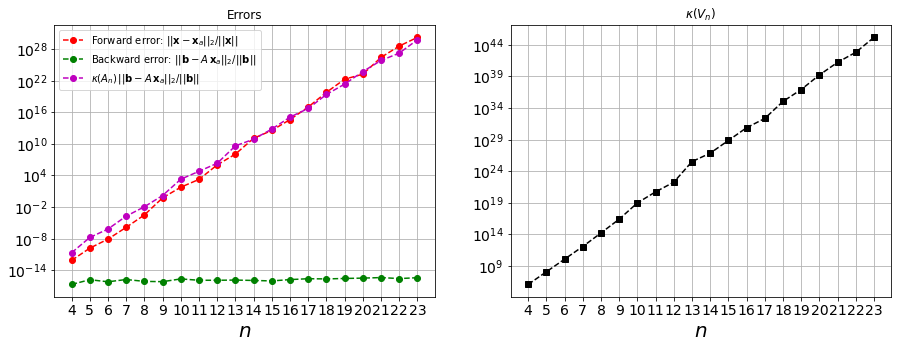

In [5]:
N=20
my_range = np.arange(4,N+4)
F_errors=np.zeros(N)
B_errors=np.zeros(N)
kappas=np.zeros(N)

np.random.seed(0)

for i,n in zip(np.arange(N),my_range):
    # Generating 'n' equalspaced points on [0,100]
    x = np.linspace(0,100,n)
    # Building Vandermonde matrix
    V = np.vander(x, increasing=True)
    # Generating a random solution
    coefficients_exact = np.random.random(n)
    # Building the RHS for the linear system of equations to be solved
    b = V @ coefficients_exact
    # Solving the associated linear system of equations
    coefficients = np.linalg.solve(V,b)
    # Computing Forward error:  ||coefficients_exact-coefficients||_2/||coefficients_exact||_2
    F_errors[i] = np.linalg.norm(coefficients-coefficients_exact)/np.linalg.norm(coefficients_exact)
    # Computing Backward error: ||b-A*coefficients||_2/||b||_2
    B_errors[i] = np.linalg.norm(b - V @ coefficients)/np.linalg.norm(b)
    # Computing the condition number
    kappas[i]   = np.linalg.cond(V,2)

plt.figure(figsize=(5,10))
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5), sharey = False)

ax1.semilogy(my_range, F_errors, marker='o', linestyle='--', color='r',label=r'Forward error: $||\mathbf{x}-\mathbf{x}_a||_2/||\mathbf{x}||$')
ax1.semilogy(my_range, B_errors, marker='o', linestyle='--', color='g',label=r'Backward error: $||\mathbf{b}-A\,\mathbf{x}_a||_2/||\mathbf{b}||$')
ax1.semilogy(my_range, kappas*B_errors, marker='o', linestyle='--', color='m', label=r'$\kappa(A_n)\,||\mathbf{b}-A\,\mathbf{x}_a||_2/||\mathbf{b}||$')
ax1.set_title('Errors')
ax1.grid(True)
ax1.set_xlabel('$n$')
ax1.legend(loc='best')
ax1.set_xticks(my_range)
ax1.set_xticklabels(my_range)

ax2.semilogy(my_range, kappas, marker='s', linestyle='--', color='k',label=r'$\kappa(V_n)$')
ax2.set_title(r'$\kappa(V_n)$')
ax2.set_xlabel('$n$')
ax2.grid(True)
ax2.set_xticks(my_range)
ax2.set_xticklabels(my_range)
plt.show()

What we see in the previous plots is the fact that solving a linear system with an ill condition matrix, like the Vandermonde matrix, it is definitely not a good idea.
Suggestion: What about if you interpolate the constant $1$ with the Vandermonde matrix, which we know that the exact solution will be the $p(x)=1$. 
This means that the constant term will be $1$ and all the other terms must be $0$.
Do you observe the same behavior?

<div id='lagrange' />

## Lagrange Interpolation
[Back to TOC](#toc)

With this method, we can interpolate data thanks to the Lagrange basis polynomials. Given a set of $n$ data points $(x_1,y_1),...,(x_n,y_n)$, the Lagrange interpolation polynomial is the following:
$$ p(x) = \sum^n_{i=1} y_i\,L_i(x),$$
where $L_i(x)$ are the Lagrange basis polynomials:
$$ L_i(x) = \prod^n_{j=1,j \neq i} \frac{x-x_j}{x_i-x_j} = \frac{x-x_1}{x_i-x_1} \cdot ... \cdot \frac{x-x_{i-1}}{x_i-x_{i-1}} \cdot \frac{x-x_{i+1}}{x_i-x_{i+1}} \cdot ... \cdot \frac{x-x_n}{x_i-x_n}$$
or simply $L_i(x)=\dfrac{l_i(x)}{l_i(x_i)}$, where $l_i(x)=\displaystyle{\prod^n_{j=1,j \neq i} (x-x_j)}$.
The key properties of these basis polynomials are the followings:
$$ L_i(x_i) = 1 $$
$$ L_{j \neq i}(x_i) = 0 $$
So, we assure that $L(x_i) = y_i$, which indeed interpolates the data.

In [6]:
def Lagrange(x, y, show=False):
    # We calculate the li's
    n = len(x)
    p = np.array([y[i]/np.prod(x[i] - np.delete(x,i)) for i in range(n)])
    
    # The function shows the data if the flag is true
    if show:
        print('Data Points: '); print([(x[i],y[i]) for i in range(n)])
        xS = sym.Symbol('x')
        L = np.dot(np.array([np.prod(xS - np.delete(x,i))/np.prod(x[i] - np.delete(x,i)) for i in range(n)]),y)
        print('Interpolation Function: '); 
        print(L)
        
    # Finally, we return a data structure with our interpolating polynomial        
    D = {'Method': 'Lagrange',
         'PrecomputedData': p,
         'x': x,
         'y': y,
         'n': n}
    return D

The following numerical experiment follows the same idea of the previous numerical experiment with the Vandermonde matrix.

In [7]:
def show_time_Lagrange(epsilon=0):
    x = np.array([0.0,2.0,3.0+epsilon,4.0,5.0,6.0])
    y = np.array([1.0,3.0,0.0,6.0,8.0,4.0])
    D = Lagrange(x,y,True)
    PlotInterpolant(D)
interact(show_time_Lagrange,epsilon=(-1,1,0.1))

interactive(children=(FloatSlider(value=0.0, description='epsilon', max=1.0, min=-1.0), Output()), _dom_classe…

<function __main__.show_time_Lagrange(epsilon=0)>

<div id='LiLagrange' />

### Plotting $L_i(x)$
[Back to TOC](#toc)

The next cell shows what $L_i(x)$ looks like.
It basically shows how a polynomial looks like when it is one at $x_i$ and zero at all the other interpolation nodes.

In [8]:
def show_time_Li(i=0, N=7):
    x = np.arange(N+1)
    y = np.zeros(N+1)
    y[i]=1
    D = Lagrange(x,y,True)
    PlotInterpolant(D,[-1,2])

i_widget = IntSlider(min=0, max=7, step=1, value=0)
N_widget = IntSlider(min=1, max=20, step=1, value=7)
def update_i_range(*args):
    i_widget.max = N_widget.value
N_widget.observe(update_i_range, 'value')

interact(show_time_Li,i=i_widget,N=N_widget)

interactive(children=(IntSlider(value=0, description='i', max=7), IntSlider(value=7, description='N', max=20, …

<function __main__.show_time_Li(i=0, N=7)>

The following example show all the $L_i(x)$ for $i\in\{1,2,\dots,N\}$ at once.
This was included thank to an inclass question!

In [9]:
def show_time_all_Li(N=3, ShowLegend=False):
    x = np.arange(1,N+1)
    xx = np.linspace(1,N,1000)
    plt.figure()
    for i in range(N):
        y = np.zeros(N)
        y[i]=1
        D = Lagrange(x,y)
        yy=EvaluateInterpolant(D, xx)
        plt.plot(xx,yy,label=r'$L_{0}(x)$'.format(i+1))
    if ShowLegend:
        plt.legend(loc='best')
    plt.grid(True)
    plt.show()
interact(show_time_all_Li,N=(2,20,1), ShowLegend=Checkbox(value=False, description="Include legend"))

interactive(children=(IntSlider(value=3, description='N', max=20, min=2), Checkbox(value=False, description='I…

<function __main__.show_time_all_Li(N=3, ShowLegend=False)>

Here you get some questions about Lagrange Interpolation:
- Explain what happens with the interpolator polynomial when you add a new point to the set of points to interpolate. **Answer: We need to recalculate the polynomial**
- Why it is not a good idea to use Lagrange interpolation for a set of points which is constantly changing? **A: Because we need to compute the whole interpolation again**
- What is the operation count of obtaining the interpolator polynomial using Lagrange? What happens with the error?

#### As an additional example we show the $\text{sinc}(x)$ function.
This function is a relative of $L_i(x)$ from Lagrange interpolation, the only difference is that it is one at one point and zero over an infinite grid!
This could be also use for interpolation, you only need to shift it a bit and you are good to go!
This is not an polynomial interpolation but it may be a good alternative.

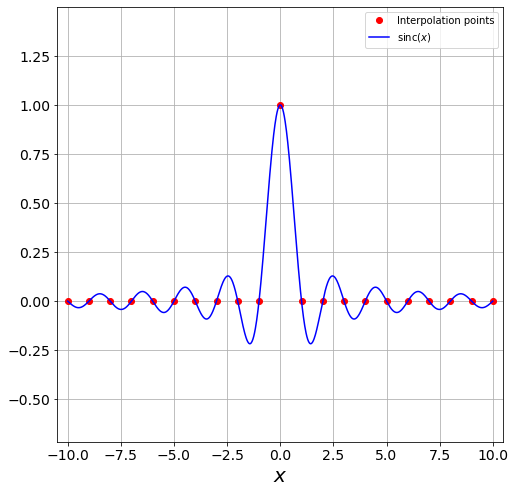

In [10]:
xD = np.arange(-10,11)
yD = np.zeros_like(xD)
yD[10] = 1
xi = np.linspace(-10,10,1000)
yi = np.sinc(xi)
plt.figure(figsize=(8,8))
plt.plot(xD,yD,'ro',label='Interpolation points')
plt.plot(xi,yi,'b-',label='sinc$(x)$')
plt.xlim(min(xi)-0.5, max(xi)+0.5)
plt.ylim(min(yi)-0.5, max(yi)+0.5)
plt.grid(True)
plt.legend(loc='best')
plt.xlabel('$x$')
#plt.ylabel('$P(x)$')
plt.show()

### Bonus: Sinc and Piecewise-linear interpolations
We add these interpolations based on the following question from class 2021-2: why don't we just use a linear or a sinc interpolator?

**See file 'Bonus - 05 - Newton's divided differences, Sinc and piecewiselinear interpolations' for a complete analysis.**

<div id='barycentric' />

## Barycentric interpolation
[Back to TOC](#toc)

The barycentric interpolation for interpolation $n$ data points $(x_1,y_1),...,(x_n,y_n)$ is of the following form:
$$ p(x) = \dfrac{\displaystyle{\sum_{i=1}^n y_i\dfrac{w_i}{(x-x_i)}}}{\displaystyle{\sum_{i=1}^n \dfrac{w_i}{(x-x_i)}}},$$
where $w_i=\dfrac{1}{l_i(x)}$ and $l_i(x)=\displaystyle{\prod_{k=1,i\neq k}^n(x-x_k)}$.

In [11]:
def Barycentric(x, y, show=False):
    W  = np.subtract.outer(x, x)
    wi  = 1/np.prod(W, axis=1, where = W!=0)
    n = len(x)

    # The function shows the data if the flag is true
    if show:
        print('Data Points: '); print([(x[i],y[i]) for i in range(n)])
        xS = sym.Symbol('x')
        N = np.sum(y*wi/(xS-x))/np.sum(wi/(xS-x))
        print('Interpolation Function: ');
        print(N)
    
    # Finally, we return a data structure with our interpolating polynomial
    D = {'Method':'Barycentric',
         'PrecomputedData': wi,
         'x': x,
         'y': y,
         'n': n}
    return D

In [12]:
def show_time_Barycentric(epsilon=0):
    x = np.array([0.0,2.0,3.0+epsilon,4.0,5.0,6.0])
    y = np.array([1.0,3.0,0.0,6.0,8.0,4.0])
    D = Barycentric(x,y,True)
    PlotInterpolant(D)
interact(show_time_Barycentric,epsilon=(-1,1,0.1))

interactive(children=(FloatSlider(value=0.0, description='epsilon', max=1.0, min=-1.0), Output()), _dom_classe…

<function __main__.show_time_Barycentric(epsilon=0)>

<div id='Error' />

## Polynomial Interpolation Error
[Back to TOC](#toc)

The interpolation error is given by:

$$ f(x)-p(x) = \frac{(x-x_1) \, (x-x_2) \, \dots \, (x-x_n)}{n!} \, f^{(n)}(c),$$

where $c$ is within the interval defined by $[\min(x,x_1,\dots,x_n),\max(x,x_1,\dots,x_n)]$.

In [13]:
def Error(f, n, xmin, xmax, method=Lagrange, points=np.linspace, plot_flag=True):
    # This function plots f(x), the interpolating polynomial, and the associated error
    # points can be np.linspace to equidistant points or Chebyshev to get Chebyshev points
    
    # These two lines generate the data that will be used in the interpolation
    x = points(xmin,xmax,n)
    y = f(x)
    
    # These two lines compute the exact value of the function being interpolated on a finer grid
    xe = np.linspace(xmin,xmax,100)
    ye = f(xe)
    
    # This two lines build the interpolant chosen, where the name of the method is 
    # passed as parameter usign the variable 'method'.
    D = method(x,y)
    yi = EvaluateInterpolant(D, xe)
    
    if plot_flag:
        plt.figure(figsize=(5,10))
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5), sharey = False)

        ax1.plot(xe, ye,'k-', label='f(x)')
        ax1.plot(x, y,'ro', label='Interpolation points',markersize=10)
        ax1.plot(xe, yi,'b-', label='Interpolation')
        ax1.set_xlim(xmin-0.5,xmax+0.5)
        ax1.set_ylim(min(yi)-0.5,max(yi)+0.5)       
        ax1.set_title('Interpolation')
        ax1.grid(True)
        ax1.set_xlabel('$x$')
        ax1.legend(loc='best') 

        ax2.semilogy(xe, abs(ye-yi),'c-', label='Absolute Error')
        ax2.set_xlim(xmin-0.5,xmax+0.5)
        ax2.set_title('Absolute Error')
        ax2.set_xlabel('$x$')
        ax2.grid(True) 
        plt.show()
        
    return max(abs(ye-yi))

In [14]:
def test_error_Lagrange(n=5):
    # Example 1
    #me = Error(lambda x: np.sin(x)**3, n, 1, 7, Lagrange)
    # Example 2
    me = Error(lambda x: (1/(1+12*x**2)), n, -1, 1, Lagrange)
    print("Max Error:", me)

In [15]:
interact(test_error_Lagrange,n=(5,25))

interactive(children=(IntSlider(value=5, description='n', max=25, min=5), Output()), _dom_classes=('widget-int…

<function __main__.test_error_Lagrange(n=5)>

<div id='runge' />

##  **Runge's Phenomenon**: It is a problem of oscillation of polynomials at the edges of the interval. 
[Back to TOC](#toc)

We are interpolating a data that is 0 almost everywhere and 1 at the middle point. 
Notice that as $n$ increases the oscilations increase and all the red dots seems to be at 0 in the plot but this is just an artifact due to the scale on the left.
The oscillations you see at the end of the interval is the Runge phenomenon.
This is due to the use of equalspaced point.

In [16]:
def Runge(n=9):
    x = np.linspace(0,1,n)
    y = np.zeros(n)
    y[int((n-1.0)/2.)]=1
    D = Barycentric(x,y,False)
    PlotInterpolant(D)
interact(Runge,n=(5,25,2))

interactive(children=(IntSlider(value=9, description='n', max=25, min=5, step=2), Output()), _dom_classes=('wi…

<function __main__.Runge(n=9)>

<div id='cheby' />

## Interpolation with Chebyshev points
[Back to TOC](#toc)

From the interpolation error defined previously, we notice on the right hand side that the only term we can actually control (besides $n$) is the actual value used for the $x_i$, for $i\in\{1,2,\dots,n\}$.
Thus, with the objective of reducing the error of the polynomial interpolation, we need to find the values of $x_1,x_2,...,x_n$ that minimize the following expression:
$$(x-x_1) \, (x-x_2) \, ... \, (x-x_n).$$

To choose these values we select the canonical interval $[-1,1]$, in particular, we expect the points to be in $-1 \leq x_1,x_2,...,x_n \leq 1$ (to use another interval we just need to do a change of variables).
This probles was already studied by Chebyshev, thus we will use the roots of the Chebyshev polynomials, also called **Chebyshev nodes** (of the first kind), which are defined by:

$$ x_i = \cos\left(\frac{(2i-1)\pi}{2n}\right), i\in\{1,2,\dots,n\} $$

In [17]:
def Chebyshev(xmin,xmax,n=5):
    # This function calculates the n Chebyshev points and plots or returns them depending on ax
    ns = np.arange(1,n+1)
    x = np.cos((2*ns-1)*np.pi/(2*n))
    y = np.sin((2*ns-1)*np.pi/(2*n))
    plt.figure(figsize=(10,5))
    plt.ylim(-0.1,1.1)
    plt.xlim(-1.1,1.1)
    plt.plot(np.cos(np.linspace(0,np.pi)),np.sin(np.linspace(0,np.pi)),'k-')
    plt.plot([-2,2],[0,0],'k-')
    plt.plot([0,0],[-1,2],'k-')
    for i in range(len(y)):
        plt.plot([x[i],x[i]],[0,y[i]],'r-')
        plt.plot([0,x[i]],[0,y[i]],'r-')
    plt.plot(x,[0]*len(x),'bo',label='Chebyshev points')
    plt.plot(x,y,'ro')
    plt.xlabel('$x$')
    plt.title('n = '+str(n))
    plt.grid(True)
    plt.legend(loc='best')
    plt.show()
def Chebyshev_points(xmin,xmax,n):
    ns = np.arange(1,n+1)
    x = np.cos((2*ns-1)*np.pi/(2*n))
    #y = np.sin((2*ns-1)*np.pi/(2*n))
    return (xmin+xmax)/2 + (xmax-xmin)*x/2
def Chebyshev_points_histogram(n=50,nbins=20):
    xCheb=Chebyshev_points(-1,1,n)
    #plt.figure()
    #plt.hist(xCheb,bins=nbins,density=True,cumulative=True)
    #plt.grid(True)
    #plt.show()
    
    plt.figure(figsize=(5,10))
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5), sharey = False)
    ax1.hist(xCheb,bins=nbins,density=True)
    ax1.grid(True)
    ax2.hist(xCheb,bins=nbins,density=True,cumulative=True)
    ax2.grid(True)
    plt.show()

The next plot shows a graphical interpretation of the Chebyshev nodes, in particular, they are the projection on the $x$-axis from equalspaced point on the unit sphere.
The angle used for defining the equalspaced point on the unit sphere are: $\theta_i=\frac{(2i-1)\pi}{2n}$, for $i\in\{1,2,\dots,n\}$.

In [18]:
interact(Chebyshev,xmin=fixed(-1),xmax=fixed(1),n=(2,50))

interactive(children=(IntSlider(value=5, description='n', max=50, min=2), Output()), _dom_classes=('widget-int…

<function __main__.Chebyshev(xmin, xmax, n=5)>

The next plot shows an histogram to explicitly show that the Chebychev nodes cluster at each end of the interval.
The left plot is an explicit histogram and the plot on the right is the cumulative distribution function.

In [19]:
interact_manual(Chebyshev_points_histogram,n=(20,10000),nbins=(20,200))

interactive(children=(IntSlider(value=50, description='n', max=10000, min=20), IntSlider(value=20, description…

<function __main__.Chebyshev_points_histogram(n=50, nbins=20)>

Moreover, these points have the an explicit expresion for the term we want to minimize,
this means,
$$ (x-x_1) \, (x-x_2) \, ... \, (x-x_n) = \dfrac{1}{2^{n-1}} \, T_n(x), $$
where $T_n(x) = \cos (n \, \arccos (x))$ is the n-th Chebyshev polynomial.
$$ 
\begin{align*}
T_0(x) &= 1, \\
T_1(x) &= x, \\
T_2(x) &= 2x^2 -1,\\
\vdots
\end{align*}
$$

It also has a recurrence relation,
$$ T_{n+1}(x) = 2 \cdot x \cdot T_n(x) - T_{n-1}(x).$$
The importance of the first identity showed in this cell is that we can bound the left-hand-side when using Chebychev points.
This is not possible when using equalspaced points.
For instance, when using Chebychehv points we have the following bound,
$$|(x-x_1) \, (x-x_2) \, ... \, (x-x_n)| = \left|\dfrac{1}{2^{n-1}} \, T_n(x)\right|\leq \dfrac{1}{2^{n-1}}.$$
This is true since $T(x) = \cos (n \, \arccos (x))$ and $|\cos(x)|\leq 1$.
This is useful when one wants to find the number of points required to interpolate a funcion to a required error.
In this case the error would become,
$$
\begin{align*}
|f(x)-p(x)| &= \left|\frac{(x-x_1) \, (x-x_2) \, \dots \, (x-x_n)}{n!} \, f^{(n)}(c)\right|\\
            &\leq \frac{1}{2^{n-1}\,n!} \, \left|f^{(n)}(c)\right|,
\end{align*}
$$
which is very nice!
We only need to pay attention to find a bound for $\left|f^{(n)}(c)\right|$ on the interval we want to interpolate the function.

In the next cell, for completeness, we plot the Chebyshev polynomials $T_n(x)$.

In [20]:
# Recursive function that returns the n-th Chebyshev polynomial evaluated at x
def T(n,x):
    if n == 0:
        return x**0
    elif n == 1:
        return x
    else:
        return 2*x*T(n-1,x)-T(n-2,x)
    
# This function plots the first n Chebyshev polynomials
def Chebyshev_Polynomials(n=2, Flag_All_Tn=False):
    x = np.linspace(-1,1,1000)
    plt.figure(figsize=(10,5))
    plt.xlim(-1, 1)
    plt.ylim(-1.1, 1.1)
    if Flag_All_Tn:
        for i in np.arange(n+1):
            y = T(i,x)
            plt.plot(x,y,label='$T_{'+str(i)+'}(x)$')
    else:
        y = T(n,x)
        plt.plot(x,y,label='$T_{'+str(n)+'}(x)$')
    plt.legend(loc='right')
    plt.grid(True)
    plt.xlabel('$x$')
    plt.show()

In [21]:
interact(Chebyshev_Polynomials,n=(0,12),Flag_All_Tn=True)

interactive(children=(IntSlider(value=2, description='n', max=12), Checkbox(value=True, description='Flag_All_…

<function __main__.Chebyshev_Polynomials(n=2, Flag_All_Tn=False)>

The follwing function compares the error obtain by interpolation a function with equalspaced points and Chebychev points.

In [22]:
def test_error_Chebyshev(n=5):
    mee = Error(lambda x: (1/(1+12*x**2)), n, -1, 1, Lagrange)
    mec = Error(lambda x: (1/(1+12*x**2)), n, -1, 1, method=Lagrange, points=Chebyshev_points)
    print("Max error (equidistants points):", mee)
    print("Max error (Chebyshev nodes):", mec)

The plots on the left show the actual function and the corresponding interpolation.
The plots in the right show the error in $\log_{10}$ scale.
Notice that we interpolation polynomial goes by the interpolation nodes exactly, this induce an error equal to $0$ and these nodes.
This behaviour explain the down spikes on the logaritmic scales, but we care about the worst case.
In the worst case the equalspaced polynomial behaves very badly, this is way polynomial interpolation with Chebyshev points is so useful.

In [23]:
interact(test_error_Chebyshev,n=(5,100,2))

interactive(children=(IntSlider(value=5, description='n', min=5, step=2), Output()), _dom_classes=('widget-int…

<function __main__.test_error_Chebyshev(n=5)>

Questions about Chebyshev:
- How can you calculate the Chebyshev points in the interval [a,b] instead of [-1,1]? **A: Using a change of variable**

## Convergence analysis 

The next set of experiments show a convergence analysis comparing equalspaced points to Chebychev points.
The $x$-axis is the number of points used and the $y$-axis is the maxmimum error obtain on the interval in logarithmic scale.
The experiment are the followings:
1. $f(x)=x^{10}$. In this case both sets of points perform similarly, however there is a significant drop in the error when $n$ is equal to $11$. This means, the error reach a minimum of $10^{-14}$ app at that number points. Why?
2. $f(x)=|x^3|$. This looks like a naive function but it is not. The equalspace points start to decrease from an error of $10^{0}$ until an error app $10^{-3}$ with approximately 10 points, it then start to increase the error. On the other hand, the Chebychev points show a decresing behavior upto $n=50$ but it only reaches an error of app $10^{-5}$, which is too high. What is the issue with this funcion?
3. $f(x)=\exp(-(x^{-2}))$. This is also a tricky function bevcause involves a division by $0$ when we evaluate it at $x=0$, but it is well defined at that points. Similarly to the first example, the equalspaced points reduce the error upto $n=10$, and then start to increase. For the Chebychev points, they decrease upto 40 points and the also show a slight increment in the error. What is the value of $f(x)$ at $x=0$?
4. $f(x)=\dfrac{1}{1+x^2}$. In this case both cases decrease the error but faster for the Chebyshev points. The main difference is that the minimum error reached for equalspaced points is about $10^{-8}$ and $10^{-13}$ for the Chebyshev points, in both cases about $n=37$.
5. $f(x)=\sin^3(x)$. In this case both cases reached an error $10^{-14}$ with $n=20$, then for equalspaced points start to increase the error right away but for Chebyshev points it starts to increase at $n=40$.

Answers to the previous questions:
1. The reason is that when $n=11$ we will be interpolation an polynomial of degree $10$ with a polynomial of degree $10$, so we can reproduce it exactly! This is why the error is $0$. When $n$ was lower, we only had an approximation. It is interesting that the error increases as we increase the number of points after $n=10$. Would it be useful to change the algorihtm used?
2. The issue is that the function is not analytic, this is because it involves the absolute value. Recall that expression for the error requires the computation of the $n$-th derivative of $f(x)$ at a $c$ point, so if the function is not differentiable, in this case the issues is at $x=0$, we could expect a bad behavior. The probles can be easily solve if we interpolate the function with a polynomial defined on $[-1,0]$ and another on $[0,1]$, ensurring the are equal at $x=0$. In this case we only need two polynomials of degree $3$ and we will be able to reproduce the function exactly! The issue is to notice this when we only have access to the computational implementation of $f(x)$ and not to the function itself.
3. 0
4. -
5. -

**We strongly suggest you to try different functions and play around!**

In [24]:
my_functions=[lambda x: x**10,
              lambda x: np.abs(x**3),
              lambda x: np.exp(-(x**-2)),
              lambda x: 1/(1+x**2),
              lambda x: np.sin(x)**3]
labels = ["x^{10}",
          "|x^3|",
          "\exp(-x^{-2})",
          "1/(1+x^2)",
          "\sin^3(x)"]
data=zip(labels,my_functions)

radio_button_function=RadioButtons(
    options=list(data),
    description='Function:',
    disabled=False
)

radio_button_interpolation_algorithm=RadioButtons(
    options=[('Vandermonde',Vandermonde),('Lagrange',Lagrange),('Barycentric',Barycentric)],
    value=Lagrange,
    description='Algorithm:',
    disabled=False
)

def convergence_study(f, method):
    n=70
    shift=2
    n_points=np.arange(shift,n)
    max_error=np.zeros(n-shift)
    max_error_es=np.zeros(n-shift)
    for i in n_points:
        max_error[i-shift] = Error(f, i, -1, 1, method, Chebyshev_points, plot_flag=False)
        max_error_es[i-shift] = Error(f, i, -1, 1, method, points=np.linspace, plot_flag=False)
    axis=plt.figure(figsize=(8,8))
    plt.semilogy(n_points,max_error,'bd',label='Chebyshev points',markersize=10)
    plt.semilogy(n_points,max_error_es,'r.',label='Equalspaced poins',markersize=16)
    plt.ylim(10**-16,10**4)
    plt.grid(True)
    plt.title('Interpolation Error')
    plt.xlabel('Number of points used in the interpolation')
    plt.ylabel('Max error on domain')
    plt.legend(loc='best')
    plt.show()
interact(convergence_study,f=radio_button_function, method=radio_button_interpolation_algorithm)

interactive(children=(RadioButtons(description='Function:', options=(('x^{10}', <function <lambda> at 0x7fc149…

<function __main__.convergence_study(f, method)>

## Analysis of time vs error for interpolation algorithms
The idea here is to understand the relationship between the error we get for each algorithm and the computation time associated.
This analysis highlights the advantage of Barycentric interpolation with Chebyshev points when the function being interpolated is analytic.
Notice that the first plot shows the computation time required for the construction of the interpolant, the second the cost of evaluation of the interpolant in a finer grid and the third one shows the sum of both times.

In [25]:
def get_error_and_time(f, xmin=-1, xmax=1, method=Lagrange, points=np.linspace):
    
    construction_times   = []
    evaluation_times     = []
    interpolation_errors = []
    
    n_range = np.array([2,4,8,16,30,50])
    
    for n in n_range:
        
        # This function plots f(x), the interpolating polynomial, and the associated error
        # points can be np.linspace to equidistant points or Chebyshev to get Chebyshev points

        # These two lines generate the data that will be used in the interpolation
        x = points(xmin,xmax,n)
        y = f(x)

        # These two lines compute the exact value of the function being interpolated on a finer grid
        xe = np.linspace(xmin,xmax,100)
        ye = f(xe)

        # This line build the interpolant chosen, where the name of the method is 
        # passed as parameter usign the variable 'method'.
        time_construction = %timeit -o -q -n 10 -r 5 method(x,y)
        construction_times.append(time_construction.average)
        D = method(x,y)
        
        time_evaluation = %timeit -o -q -n 10 -r 5 EvaluateInterpolant(D, xe)
        evaluation_times.append(time_evaluation.average)
        yi = EvaluateInterpolant(D, xe)
        
        if max(abs(ye-yi))<1e-16:
            interpolation_errors.append(1e-16)
        else:
            interpolation_errors.append(max(abs(ye-yi)))
        
    return construction_times, evaluation_times, interpolation_errors


def analysis_of_time_vs_error_of_interpolation_algorihtms(f):
    # List of methods
    list_of_methods = [('Vandermonde',Vandermonde),('Lagrange',Lagrange),('Barycentric',Barycentric)]
    # List of type of points
    list_of_points = [('equalspaced',np.linspace), ('Chebyshev',Chebyshev_points)]
    list_output_data = []
    k = 1
    for name_method, method in list_of_methods:
        for points_name, points in list_of_points:
            # We exclude SincInterpolator for Chebyshev points because it need equalspaced data
            if (name_method=='SincInterpolator' and points_name=='Chebyshev'):
                continue
            tic = time.time()
            c_time, e_time, errors = get_error_and_time(f, xmin=-1, xmax=1, method=method, points=points)
            print(k,'/ 6: ',name_method, ',' , points_name, ', time:',time.time()-tic,'[s]')
            k=k+1
            list_output_data.append([name_method, points_name, c_time, e_time, errors])
    
    markers = ['8','>','<','^','v','o','d','D','H','h','*','p','s']
    
    fig = plt.figure(figsize=(16,16))
    plt.rcParams.update({'font.size': 12})
    
    k = 0
    for data in list_output_data:
        name_method, points_name, c_time, e_time, errors = data
            
        ax = plt.subplot(2,2,1)
        plt.title('Construction time')
        plt.loglog(errors, c_time, markers[k], lw=2.0, ms=10, label=name_method+', '+points_name)
        ax = plt.subplot(2,2,2)
        plt.title('Evaluation time')
        plt.loglog(errors, e_time, markers[k], lw=2.0, ms=10, label=name_method+', '+points_name)
        ax = plt.subplot(2,2,3)
        plt.title('Construction + evaluation times')
        plt.loglog(errors, np.array(c_time)+np.array(e_time), markers[k], lw=2.0, ms=10, label=name_method+', '+points_name)
        k=k+1
    
    plt.legend(loc='lower left', ncol=1, fancybox=True, shadow=True, numpoints=1, bbox_to_anchor=(1,0))
    
    for i in range(3):
        ax = plt.subplot(2,2,i+1)
        plt.xlabel("Absolute Error")
        plt.ylabel("Time in seconds")
        plt.grid('on')
    plt.show()

interact(analysis_of_time_vs_error_of_interpolation_algorihtms,f=radio_button_function)

interactive(children=(RadioButtons(description='Function:', options=(('x^{10}', <function <lambda> at 0x7fc149…

<function __main__.analysis_of_time_vs_error_of_interpolation_algorihtms(f)>

**Warning**: Notice that this experiment shows a _competitive_ behavior of the Vandermonde matrix but don't forget that the Vandermonde matrix is very ill-conditioned!

<div id='py' />

## Python Modules and Functions
[Back to TOC](#toc)

Interpolation: 

https://numpy.org/doc/stable/reference/generated/numpy.polyfit.html

Vandermonde Matrix: 

https://numpy.org/doc/stable/reference/generated/numpy.vander.html

Lagrange Interpolator: 

https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.lagrange.html

Barycentric Interpolator:

https://people.maths.ox.ac.uk/trefethen/barycentric.pdf

https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.BarycentricInterpolator.html

Chebyshev Points for the First Kind:

https://numpy.org/doc/stable/reference/generated/numpy.polynomial.chebyshev.chebroots.html

<div id='acknowledgements' />

# Acknowledgements
[Back to TOC](#toc)

* _Material created by professor Claudio Torres_ (`ctorres@inf.utfsm.cl`) _and assistants: Laura Bermeo, Alvaro Salinas, Axel Simonsen and Martín Villanueva. DI UTFSM. April 2016._
* _Material modified by Cristopher Arenas. May 2017._
* _Material modified by Claudio Torres. May 2017._
* _Bug fixed by Cristobal Carmona. April 2018._
* _Update June 2020 - v1.25 - C.Torres_ : Fixing formatting issues.
* _Update June 2020 - v1.26 - C.Torres_ : Adding "ylim" argumento to Interpolation_Plot(D,ylim=None) and addint "show_time_Li".
* _Update June 2020 - v1.27 - C.Torres_ : Adding comment that the Chebyshev nodes used are of the first kind and "Chebyshev_points_histogram".
* _Update May 2021 - v1.28 - C.Torres_ : Improving format, adding cumulative histogram in "Chebyshev_points_histogram", updating Python modules links, implementing Barycentric interpolation, changing functions names: Interpolation_Plot->PlotInterpolant, Y->EvaluateInterpolant; adding field 'n' to data structure 'D' used for building interpolant, several changes everywhere adding more explanations.
* _Update May 2021 - v1.29 - C.Torres_ : Adding "show_time_all_Li" thanks to Felipe Samur question during class. Thanks Felipe! Changing reference tu sympy from 'sp' to 'sym'.
* _Update May 2021 - v1.30 - C.Torres_ : Adding radio buttons to last examples.
* _Update October 2021 - v1.31 - C.Torres_ : Adding Vandermonde matrix analysis about being ill-conditioned.
* _Update October 2021 - v1.32 - C.Torres_ : Fixing typos.
* _Update October 2021 - v1.33 - C.Torres_ : Removing Newton's divided differences and moving it to 'Bonus - 05 - Newton's divided differences, Sinc and piecewiselinear interpolations'.